#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento


# Project 2: Modern Low Footprint Cyber Attack Protection
## Reading the Data
The code below reads the data from the dataset and creates dataframes. Values of "-" are treated as N/A and entries with this value are dropped from the dataframe. Attack_cat is also dropped due to the fact that it gives additional information to the model that we do not want (skewing the accuracy).

In [271]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from collections.abc import Sequence
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

path = "./dataset/"
save_path = "./models/"

#Defines filepaths for the data sets
training_set = os.path.join(path,"UNSW_NB15_training-set.csv")
test_set = os.path.join(path,"UNSW_NB15_test-set.csv")

#Loads files into dataframes
df_training_set = pd.read_csv(training_set, na_values = ['-'])
df_test_set = pd.read_csv(test_set, na_values = ['-'])

#Removes rows with a "-" in any column
df_training_set.dropna(inplace = True)
df_test_set.dropna(inplace = True)

df_training_set.drop('attack_cat', axis = 1, inplace = True)
df_test_set.drop('attack_cat', axis = 1, inplace = True)

print(len(df_training_set))
print(len(df_test_set))

df_training_set.head()

81173
35179


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,1,3,1,1,0,2,1,0,0
11,12,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,...,1,1,2,0,0,0,1,1,0,0
15,16,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,...,1,1,4,0,0,0,2,1,0,0
17,18,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,...,1,1,2,0,0,1,1,3,0,0
21,22,0.338017,tcp,http,FIN,10,6,998,268,44.376468,...,1,1,1,0,0,1,2,3,0,0


## Data Filtering
The code below removes categorical values that are not present in both datasets. As visible via the print statements, roughly 600 entries are dropped from the training set, while only one is dropped from the test set.

In [272]:
#Removes categorical values not present in both datasets
categorical_columns = ['proto', 'service', 'state']

for column in categorical_columns:
    unique_values_training = set(df_training_set[column].unique())
    unique_values_test = set(df_test_set[column].unique())

    print(unique_values_training)
    print(unique_values_test)
    
    common_values = unique_values_training.intersection(unique_values_test)
    print(common_values)

    df_training_set = df_training_set[df_training_set[column].isin(common_values)]
    df_test_set = df_test_set[df_test_set[column].isin(common_values)]

print(len(df_training_set))
print(len(df_test_set))

{'udp', 'tcp'}
{'udp', 'tcp'}
{'tcp', 'udp'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'FIN', 'CON', 'INT', 'RST', 'REQ'}
{'ACC', 'FIN', 'CON', 'INT', 'REQ'}
{'CON', 'FIN', 'REQ', 'INT'}
81159
35178


The columns 'id' and 'is_sm_ips_ports' are dropped from the dataframes: 'id' is irrelevent to the data at hand, and 'is_sm_ips_ports' causes errors when calculating z scores (likely because it is always 0).

In [273]:
df_training_set.drop('id', axis = 1, inplace = True)
df_training_set.drop('is_sm_ips_ports', axis = 1, inplace = True)

df_test_set.drop('id', axis = 1, inplace = True)
df_test_set.drop('is_sm_ips_ports', axis = 1, inplace = True)

The numerical data is then normalized via z-score.

In [274]:
#Finds numerical data (columns that are not categorical)
non_z_columns = ['proto', 'service', 'state', 'label']
numerical_columns = set(df_training_set.columns.symmetric_difference(non_z_columns))

from scipy.stats import zscore

def z_score_numerical(df, names):
    for name in names:
        df[name] = zscore(df[name])

z_score_numerical(df_training_set, numerical_columns)
z_score_numerical(df_test_set, numerical_columns)

Finally, the next bit of code encodes the now-filtered categorical values into their own columns.

In [275]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue) given a dataframe and a list of column names
def encode_text_dummy_loop(df, names):
    for name in names:
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = "{}-{}".format(name, x)
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)

encode_text_dummy_loop(df_training_set, categorical_columns)
encode_text_dummy_loop(df_test_set, categorical_columns)

df_training_set.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-CON,state-FIN,state-INT,state-REQ
3,0.176163,-0.047988,-0.044583,-0.055887,-0.077790,-0.624202,-1.042388,1.554525,-0.610177,-0.216555,...,False,False,False,False,False,False,False,True,False,False
11,0.267845,0.216818,0.076667,0.169739,-0.069504,-0.624034,-1.042388,1.554525,-0.607597,-0.211860,...,False,False,True,False,False,False,False,True,False,False
15,-0.198561,-0.100949,-0.135522,-0.057872,-0.082214,2.286835,0.822749,-0.717536,2.795602,-0.219844,...,False,False,False,True,False,False,False,False,True,False
17,-0.110864,-0.058580,-0.074896,-0.054948,-0.075916,-0.624030,-1.042388,1.554525,-0.610017,-0.200752,...,False,False,False,False,False,False,False,True,False,False
21,-0.123240,-0.058580,-0.090053,-0.054389,-0.080674,-0.624023,0.822749,1.554525,-0.609948,-0.214652,...,False,False,False,False,False,False,False,True,False,False


The data is now mostly ready, just needing to be formatted in X y.

In [276]:
# Ensure both sets have the same columns after encoding
df_training_set, df_test_set = df_training_set.align(df_test_set, join='inner', axis=1)

# Features (X) and Target (y)
X_train = df_training_set.drop('label', axis=1)
y_train = df_training_set['label']
X_test = df_test_set.drop('label', axis=1)
y_test = df_test_set['label']

# Check data shapes
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (81159, 56)
Test set shape: (35178, 56)


# Model Creation and Training
First, we create a traditional FCNN model using relu and sigmoid (for the final classification layer). The model is then trained.

In [277]:
# Define FCNN Model Function
def create_fcnn(input_shape=(X_train.shape[1],), activation='relu', neuron_count_array=[64,32]):
    model = Sequential()
    model.add(Dense(neuron_count_array[0], activation=activation, input_shape=(input_shape))) # Initial layer, with input shape
    for i in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[i+1], activation=activation))    #In between layers
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create FCNN Model
model_fcnn = create_fcnn((X_train.shape[1],))

# Compile model
model_fcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping & model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_path, 'fcnn_best_model.keras'), save_best_only=True)

# Train the model
history_fcnn = model_fcnn.fit(X_train, y_train, 
                               validation_split=0.2, 
                                epochs=50, 
                                batch_size=32, 
                                callbacks=[early_stopping, model_checkpoint])

model_fcnn.summary()

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step - accuracy: 0.9660 - loss: 0.1098 - val_accuracy: 0.9997 - val_loss: 0.0059
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9760 - loss: 0.0578 - val_accuracy: 0.9992 - val_loss: 0.0052
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.9766 - loss: 0.0529 - val_accuracy: 0.9967 - val_loss: 0.0086
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9771 - loss: 0.0509 - val_accuracy: 0.9999 - val_loss: 0.0030
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.9782 - loss: 0.0501 - val_accuracy: 0.9977 - val_loss: 0.0065
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.9788 - loss: 0.0498 - val_accuracy: 0.9975 - val_loss: 0.0061
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9784 - loss: 0.0487 - val_accuracy: 0.9975 - val_loss: 0.0069


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,285 (67.52 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,524 (45.02 KB)

Next, we create a CNN model (which includes kernels). The same procedure is used.

In [278]:
# Define CNN Model Function
def create_cnn(input_shape=(X_train.shape[1], 1), activation='relu', neuron_count_array=[64,32], kernel_size_array=[3,3]):
    model = Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_size_array[0], activation=activation, input_shape=(input_shape)))
    for i in range(len(kernel_size_array)-1):
        model.add(layers.Conv1D(filters=64, kernel_size=kernel_size_array[i+1], activation=activation))
        model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    for j in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[j], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create CNN Model
model_cnn = create_cnn((X_train.shape[1], 1))

# Compile model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping & model checkpoint
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_cnn = ModelCheckpoint(filepath=os.path.join(save_path, 'cnn_best_model.keras'), save_best_only=True)

# Train the model
history_cnn = model_cnn.fit(X_train, y_train, 
                             epochs=50, 
                             batch_size=32, 
                             validation_split=0.2,  # Use 20% of training data for validation
                             callbacks=[early_stopping_cnn, model_checkpoint_cnn])

model_cnn.summary()

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9625 - loss: 0.1062 - val_accuracy: 0.9972 - val_loss: 0.0080
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9791 - loss: 0.0534 - val_accuracy: 0.9978 - val_loss: 0.0057
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9792 - loss: 0.0495 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9797 - loss: 0.0484 - val_accuracy: 0.9976 - val_loss: 0.0073
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9801 - loss: 0.0468 - val_accuracy: 0.9977 - val_loss: 0.0057
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9807 - loss: 0.0461 - val_accuracy: 0.9969 - val_loss: 0.0081


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 54, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 52, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,885 (1.29 MB)

 Trainable params: 112,961 (441.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,924 (882.52 KB)

# Evaluating the Models
The following function will allow us to evaluate our models given test data. It prints the confusion matrix as well as the ROC.

In [279]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_data):
    # Make predictions on the test set
    y_pred = model.predict(test_data)
    # Convert probabilities to binary predictions if your model outputs probabilities
    y_pred_classes = (y_pred > 0.5).astype(int)  # Use the appropriate threshold

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    # Print the results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Get the probability predictions
    y_pred_prob = model.predict(test_data)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



This is the evaluation of the FCNN model.

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Confusion Matrix:
 [[ 6935  2689]
 [   12 25542]]
Precision: 0.9047500974106478
Recall: 0.9995304061986382
F1-Score: 0.949781537603421


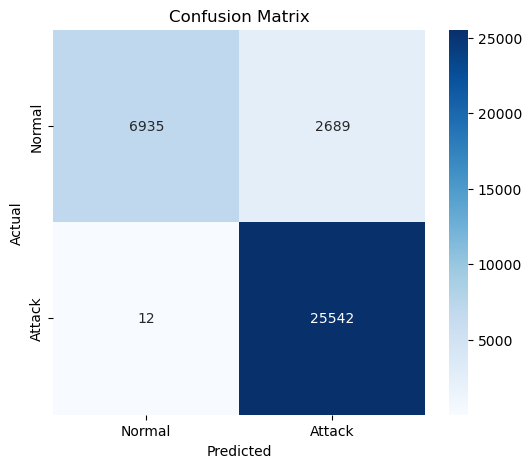

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


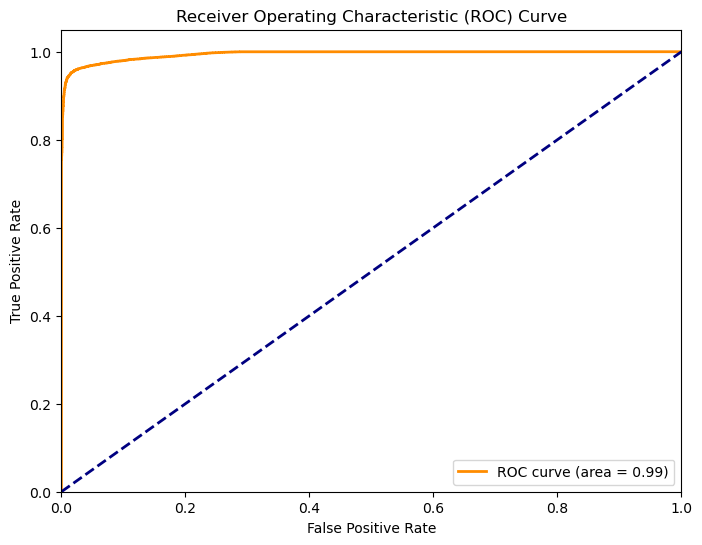

In [280]:
evaluate_model(model_fcnn, X_test)

This is the evaluation of the CNN model.

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
Confusion Matrix:
 [[ 7431  2193]
 [  173 25381]]
Precision: 0.9204685573366215
Recall: 0.9932300226970338
F1-Score: 0.9554660442704412


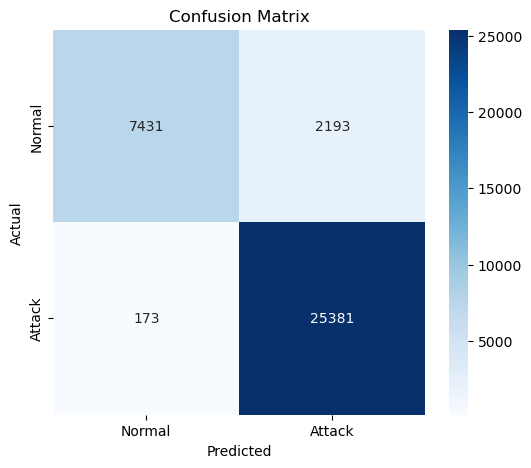

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


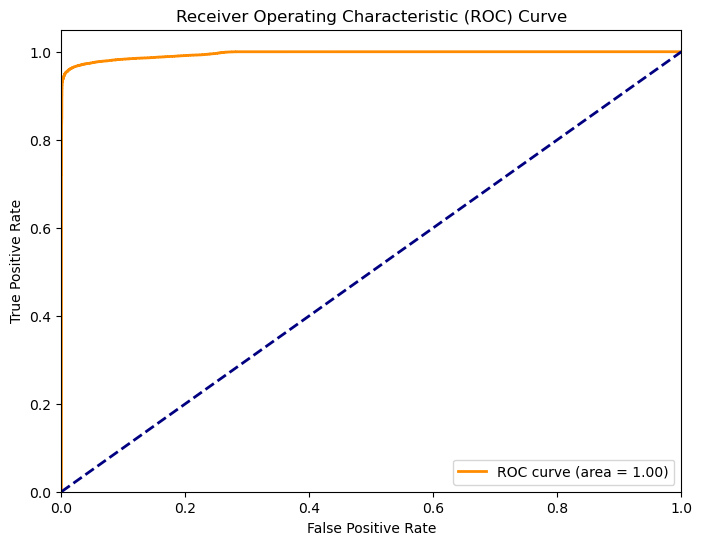

In [281]:
evaluate_model(model_cnn, X_test)

With these two initial models complete, the rest of this notebook contains models with different activation methods, layer counts/sizes, and kernel counts/sizes (when applicable).
# Model Experimentation

In [282]:
create_fcnn()

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_53, built=True>